In [46]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import utils
#import xgboost as xgb
%matplotlib inline

RANDOM_SEED = 4321
np.random.seed = RANDOM_SEED


In [2]:
train = pd.read_csv('data/train_all_features.csv')
test = pd.read_csv('data/test_all_features.csv')

train_x = train.drop(['CUST_COD', 'DEFAULT PAYMENT JAN'], axis=1)
train_y = train['DEFAULT PAYMENT JAN'].ravel()
test_x = test.drop(['CUST_COD', 'DEFAULT PAYMENT JAN'], axis = 1)

x_train, x_validation, y_train, y_validation = train_test_split(train_x, 
                                            train_y, test_size=0.3, random_state=RANDOM_SEED)
x_test = test_x.copy()

x_train.index = np.arange(len(x_train))
x_validation.index = np.arange(len(x_validation))


# Logistic Regression #

In [4]:
lr_params = {
    'C' : [1],
    'fit_intercept' : [True],
    'max_iter' : [50], #TODO: change
    'solver' : ['newton-cg'],
    'tol' : [1e-4],
    'random_state' : [RANDOM_SEED]
}

log_regression = linear_model.LogisticRegression()
acc_scorer = make_scorer(accuracy_score)
log_reg_models = GridSearchCV(log_regression, lr_params, scoring=acc_scorer, n_jobs=-1)
log_reg_models = log_reg_models.fit(x_train, y_train)

lr_best = log_reg_models.best_estimator_
lr_best = lr_best.fit(x_train, y_train)

lr_model = {
    'Name' : 'Logistic regression', 
    'CVScore' : log_reg_models.best_score_, 
    'CVStd' : log_reg_models.cv_results_['std_test_score'][log_reg_models.best_index_],
    'Result_train' : lr_best.predict(x_train),
    #'Result_test' : lr_best.predict(x_test),
    'Model' : lr_best
}

In [5]:
print('Best model - avg:', 
      lr_model['CVScore'],
      '+/-', 
      lr_model['CVStd'])
print('\n')
print(log_reg_models.best_estimator_)

('Best model - avg:', 0.80205122754809222, '+/-', 0.00097089237459969751)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=4321, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)


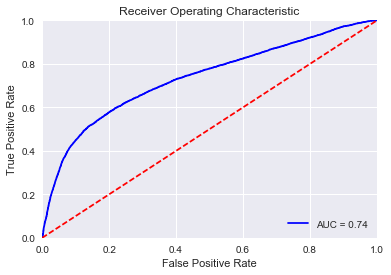

(0.30852897016996161, 0.51269078337127916)

In [47]:
utils.plot_roc_curve(lr_best, train_x, train_y)
utils.get_best_threshold(lr_best, train_x, train_y, f1_score)

# Random Forest #

In [6]:
rf_params = {
    'n_estimators' :  [10], #TODO
    'max_features' : ['log2'],
    'criterion' : ['gini'],
    'min_samples_split' :  [16], #TODO
    'min_samples_leaf' : [1], #TODO
    'random_state' : [RANDOM_SEED]
}

random_forest = ensemble.RandomForestClassifier()
acc_scorer = make_scorer(accuracy_score)
rf_models = GridSearchCV(random_forest, rf_params, scoring=acc_scorer, n_jobs=-1)
rf_models = rf_models.fit(x_train, y_train)

rf_best = rf_models.best_estimator_
rf_best = rf_best.fit(x_train, y_train)

rf_model = {
    'Name' : 'Random forest', 
    'CVScore' : rf_models.best_score_, 
    'CVStd' : rf_models.cv_results_['std_test_score'][rf_models.best_index_],
    'Result_train' : rf_best.predict(x_train),
    #'Result_test' : rf_best.predict(x_test),
    'Model' : rf_best
}

In [7]:
best_idx = rf_models.best_index_
print('Best model - avg:', 
      rf_model['CVScore'],
      '+/-', 
      rf_model['CVStd'])
print('\n')
print(rf_models.best_estimator_)

('Best model - avg:', 0.807471569773621, '+/-', 0.0034044723707162619)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)


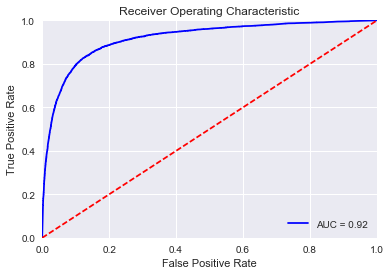

(0.34113113229481512, 0.74113873295910182)

In [48]:
utils.plot_roc_curve(rf_best, train_x, train_y)
utils.get_best_threshold(rf_best, train_x, train_y, f1_score)

# SVM #

In [8]:
train_test = pd.concat([x_train, x_validation], ignore_index=True) # Left out x_test
train_test_normalized = preprocessing.scale(train_test)
x_train_normalized = train_test_normalized[:len(x_train), :]
x_test_normalized = train_test_normalized[len(x_train):len(x_train) + len(x_test), :]
x_validation_normalized = train_test_normalized[len(x_train) + len(x_test):, :]

In [9]:
svm_params = {
    'C' : [0.3],
    'kernel' : ['rbf'],
    'tol' : [1e-3],
    'degree' : [2],
    'random_state' : [RANDOM_SEED]
}
acc_scorer = make_scorer(accuracy_score)
svc = SVC()
svc_classifiers = GridSearchCV(svc, svm_params, scoring=acc_scorer, n_jobs=-1)
svc_classifiers = svc_classifiers.fit(x_train_normalized, y_train)

svc_best = svc_classifiers.best_estimator_
svc_best = svc_best.fit(x_train_normalized, y_train)

svc_model = {
    'Name' : 'SVC', 
    'CVScore' : svc_classifiers.best_score_, 
    'CVStd' : svc_classifiers.cv_results_['std_test_score'][svc_classifiers.best_index_],
    'Result_train' : svc_best.predict(x_train_normalized),
    #'Result_test' : svc_best.predict(x_test_normalized),
    'Model' : svc_best
}

In [10]:
best_idx = svc_classifiers.best_index_
print('Best model - avg:', 
      svc_model['CVScore'], 
      '+/-', 
      svc_model['CVStd'])
print()
print(svc_classifiers.best_estimator_)

('Best model - avg:', 0.81050058454671059, '+/-', 0.0012748768346108601)
()
SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=4321, shrinking=True,
  tol=0.001, verbose=False)


In [49]:
utils.plot_roc_curve(svc_best, train_x, train_y)
utils.get_best_threshold(svc_best, train_x, train_y, f1_score)

AttributeError: predict_proba is not available when  probability=False

# Adaboost #

In [11]:
ada_params = {
    'n_estimators' : [20],#TODO
    'learning_rate' : [0.1], #TODO
    'algorithm' : ['SAMME.R'],
    'random_state' : [RANDOM_SEED]
}

acc_scorer = make_scorer(accuracy_score)
ada_class = ensemble.AdaBoostClassifier()
ada_classifiers = GridSearchCV(ada_class, ada_params, scoring=acc_scorer, n_jobs=-1)
ada_classifiers = ada_classifiers.fit(x_train, y_train)

ada_best = ada_classifiers.best_estimator_
ada_best = ada_best.fit(x_train, y_train)

ada_model = {
    'Name' : 'Ada boost', 
    'CVScore' : ada_classifiers.best_score_, 
    'CVStd' : ada_classifiers.cv_results_['std_test_score'][ada_classifiers.best_index_],
    'Result_train' : ada_best.predict(x_train),
    #'Result_test' : ada_best.predict(x_test),
    'Model' : ada_best
}

In [12]:
best_idx = ada_classifiers.best_index_
print('Best model - avg:', 
      ada_model['CVScore'], 
      '+/-', 
      ada_model['CVStd'])
print()
print(ada_classifiers.best_estimator_)

('Best model - avg:', 0.81841853544478693, '+/-', 0.00052083449411995271)
()
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=20, random_state=4321)


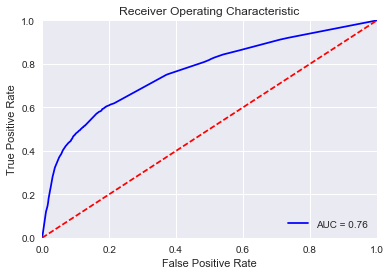

(0.35248198400294128, 0.53320787265741398)

In [50]:
utils.plot_roc_curve(ada_best, train_x, train_y)
utils.get_best_threshold(ada_best, train_x, train_y, f1_score)

# Multi Layer Perceptron #

In [13]:
from sklearn.preprocessing import StandardScaler

mlp_params = {
    'hidden_layer_sizes': [10], #TODO
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001], #TODO
    'batch_size': ['auto'],
    'learning_rate': ['constant'],
    'max_iter': [100], #TODO
    'momentum': [0.9], #TODO
    'early_stopping': [True] #Considerare se metterlo a false, dovrebbe stoppare il processo prima
}

scaler=StandardScaler()
x_new_train = scaler.fit_transform(x_train)

acc_scorer = make_scorer(accuracy_score)
mlp_class = MLPClassifier()
mlp_classifiers = GridSearchCV(mlp_class, mlp_params, scoring=acc_scorer, n_jobs=-1)
mlp_classifiers = mlp_classifiers.fit(x_new_train, y_train)

mlp_best = mlp_classifiers.best_estimator_
mlp_best = mlp_best.fit(x_train, y_train)

mlp_model = {
    'Name' : 'Multi Layer Perceptron classifier', 
    'CVScore' : mlp_classifiers.best_score_, 
    'CVStd' : mlp_classifiers.cv_results_['std_test_score'][mlp_classifiers.best_index_],
    'Result_train' : mlp_best.predict(x_train),
    #'Result_test' : ada_best.predict(x_test),
    'Model' : mlp_best
}

In [14]:
best_idx = mlp_classifiers.best_index_
print('Best model - avg:', 
      mlp_model['CVScore'], 
      '+/-', 
      mlp_model['CVStd'])
print()
print(mlp_classifiers.best_estimator_)

('Best model - avg:', 0.81108513125730686, '+/-', 0.0010239289853312288)
()
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


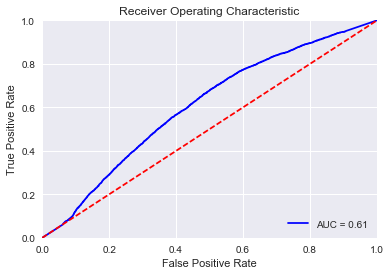

(4.6169752719773874e-74, 0.39873722979786907)

In [51]:
utils.plot_roc_curve(mlp_best, train_x, train_y)
utils.get_best_threshold(mlp_best, train_x, train_y, f1_score)

# KNN #

In [33]:
knn_params = {
    'n_neighbors' : [3], #TODO
    'algorithm' : ['kd_tree']
}

acc_scorer = make_scorer(accuracy_score)
knn_class = KNeighborsClassifier()
knn_classifiers = GridSearchCV(knn_class, knn_params, scoring=acc_scorer, n_jobs=-1)
knn_classifiers = knn_classifiers.fit(x_new_train, y_train)

knn_best = knn_classifiers.best_estimator_
knn_best = knn_best.fit(x_train, y_train)

knn_model = {
    'Name' : 'K-Nearest Neighbors classifier', 
    'CVScore' : knn_classifiers.best_score_, 
    'CVStd' : knn_classifiers.cv_results_['std_test_score'][knn_classifiers.best_index_],
    'Result_train' : knn_best.predict(x_train),
    #'Result_test' : ada_best.predict(x_test),
    'Model' : knn_best
}

In [34]:
best_idx = knn_classifiers.best_index_
print('Best model - avg:', 
      knn_model['CVScore'], 
      '+/-', 
      knn_model['CVStd'])
print('\n')
print(knn_classifiers.best_estimator_)

Best model - avg: 0.771495376767 +/- 0.000407850318666


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


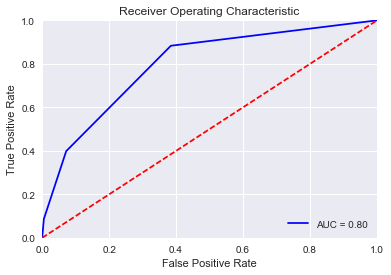

(0.33333333333333331, 0.54565296471444158)

In [52]:
utils.plot_roc_curve(knn_best, train_x, train_y)
utils.get_best_threshold(knn_best, train_x, train_y, f1_score)

# Ensemble #

In [15]:
class Ensemble:
    def __init__(self, models, svc_last=True):
        self.models = models[:]
        self.svc_last = svc_last
    
    def fit(self, X_train, y_train, X_train_normalized):
        fitted_models = [m['Model'].fit(X_train, y_train) for m in self.models]
        for i in range(len(fitted_models)):
            self.models[i]['Model'] = fitted_models[i]
    
    def predict(self, X_test, X_test_normalized):
        predictions = []
        for m in self.models:
            if m['Name'] == 'SVC':
                predictions.append(m['Model'].predict(X_test_normalized))
            else:
                predictions.append(m['Model'].predict(X_test))
        
        df = pd.DataFrame(np.array(predictions), index=[m['Name'] for m in self.models])
        
        return df.apply(lambda x : 0 if np.sum(x) <= 2 else 1)

    def __repr__(self):
        return "Ensemble(" + ', '.join([m['Name'] for m in self.models]) + ")"

In [16]:
ens = Ensemble([rf_model, ada_model, mlp_model, lr_model, svc_model])
predictions = ens.predict(x_test, x_test_normalized).values

In [17]:
ensemble_model = {
    'Name' : 'Ensemble', 
    'CVScore' : 0, 
    'CVStd' : 0,
    'Result_train' : [],
    'Result_test' : predictions,
    'Model' : ens
}

answer_df = pd.DataFrame()
answer_df['CUST_COD'] = test['CUST_COD']
answer_df['DEFAULT PAYMENT JAN'] = predictions

answer_df.to_csv('results_ensemble.csv', index=False)

# Stacking #

In [18]:
def get_stacked(x, x_normalized, models):
    predictions = []
    for m in models:
        if m['Name'] == 'SVC':
            predictions.append(m['Model'].predict(x_normalized))
        else:
            predictions.append(m['Model'].predict(x))
    stack = pd.DataFrame(np.array(predictions).T, columns=[m['Name'] for m in models])
    return pd.concat([x, stack], axis=1)

stacking_models = [rf_model, ada_model, svc_model]
train_stacked = get_stacked(x_train, x_train_normalized, stacking_models)
test_stacked = get_stacked(x_test, x_test_normalized, stacking_models)

In [25]:
ada_params = {
    'n_estimators' : [20],#TODO
    'learning_rate' : [0.1], #TODO
    'algorithm' : ['SAMME.R'],
    'random_state' : [RANDOM_SEED]
}

ada_stacked = ensemble.AdaBoostClassifier()
acc_scorer = make_scorer(accuracy_score)
ada_stacked_grid = GridSearchCV(ada_stacked, ada_params, scoring=acc_scorer)
ada_stacked_grid = ada_stacked_grid.fit(train_stacked, y_train)

stacked_best = ada_stacked_grid.best_estimator_.fit(train_stacked, y_train)

stacked_model = {
    'Name' : 'Stacking', 
    'CVScore' : ada_stacked_grid.best_score_, 
    'CVStd' : ada_stacked_grid.cv_results_['std_test_score'][ada_stacked_grid.best_index_],
    'Result_train' : ada_stacked_grid.predict(train_stacked),
    'Result_test' : ada_stacked_grid.predict(test_stacked),
    'Model' : stacked_best
}

In [26]:
print('Best model - avg:', 
      stacked_model['CVScore'], 
      '+/-', 
      stacked_model['CVStd'])
print('\n')
print(stacked_best)

('Best model - avg:', 0.90195557444999463, '+/-', 0.0018421363077366696)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=20, random_state=4321)


In [53]:
utils.plot_roc_curve(stacked_best, train_x, train_y)
utils.get_best_threshold(stacked_best, train_x, train_y, f1_score)

ValueError: Number of features of the model must match the input. Model n_features is 84 and input n_features is 81 